### Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline 
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)}) 

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Google Drive mounten
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [3]:
data = pd.read_csv('../data/Energieverbrauch.csv')
data.head()

,Date,Consumption
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel. 
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen: 
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren. 
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt. 
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [5]:
data['Weekday'] = data.index.weekday

# Das hier noch anpassen
data['Year'] = data.index.year
data['Month'] = data.index.month

## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren. 
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [6]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]

## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern. 
- Versuchen Sie zu verstehen, was passiert. Was macht die Hilfsfunktion?




Antwort: Splitted die Daten in Training, Validierung und Testmengen. Die Mengen haben alle "Consumption" als Y-Achse. Nicht-features werden gedroppt. 

In [7]:
# Hilfsfunktion
def generate_sets(df): 
    
    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])        
        
    # Auswahl der Label durch Auswahl der entsprechenden Spalten                 
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']
        
    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)                                                                          
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

## Aufgabe 6
- Oben in der Hilfsfunktion wird das Merkmal 'Year' aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?
- Weiterhin wird aus X_train/validate/test die Spalte "Consumption" gelöscht. Wieso macht das Sinn?
- Wozu braucht man Trainings-, Validierungs- und Testmenge?

Antwort: 

- "Year" wird entfernt, um das Modell nicht zu überfiten.
- "Consumption" wird entfernt, da es die Y-Achse ist und nicht in den Features enthalten sein darf.
- Trainingsmenge wird zum Trainieren des Modells verwendet. Validierungs- und Testmenge werden zum Testen des Modells verwendet. Validierungs- und Testmenge sind unabhängig von der Trainingsmenge.
Diese werden benötigt, damit das Modell nicht überfitet.

In [8]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [9]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische 
                   Darstellung des Entscheidungsbaumes)
                   
    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann          
    '''
    
    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)
    
    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_splkit und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)
    
    # Optionale Ausgabe generieren
    if output:
        
        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)
        
        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
    
    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren. 
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen. 
- Diese enthält die Parameter min_samples_split und min_samples_leaf
- Was bedeuten diese Parameter? Versuchen Sie dies mithilfe der Dokumentation zu klären:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Was passiert wenn Sie diese Parameter verändern?
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. min_samples_split zwischen 2 und 2000. Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum

- min_samples_split: The minimum number of samples required to split an internal node
- min_samples_leaf: The minimum number of samples required to be at a leaf node

In [10]:
def find_best_parameters(X_train, y_train, split_value_range = range(2,500), leaf_value_range=range(1,5)):
    '''
    Finds the best values for the hyperparameters min_samples_split and min_samples_leaf for a decision tree regressor.

    Inputs:
    X_train (df): Dataframe with the feature vectors of the training set
    y_train (df): Dataframe with the labels of the training set
    split_value_range (range): range of values for the hyperparameter min_samples_split
    leaf_value_range (range): range of values for the hyperparameter min_samples_leaf

    Outputs:
    best_samples_split (int): best value for the hyperparameter min_samples_split
    best_samples_leaf (int): best value for the hyperparameter min_samples_leaf
    '''
    from sklearn.model_selection import GridSearchCV

    # set up the grid search and fit it to the training data
    param_grid = dict(min_samples_split=split_value_range, min_samples_leaf=leaf_value_range) # parameters to be tested
    grid = GridSearchCV(DecisionTreeRegressor(random_state = 0), param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1)
    grid.fit(X_train, y_train)

    # get the best hyperparameter values from the results dataset
    results = pd.DataFrame(grid.cv_results_) # convert to dataframe for easier handling
    best_samples_split = results.loc[results['rank_test_score'] == 1]["param_min_samples_split"].values[0]
    best_samples_leaf = results.loc[results['rank_test_score'] == 1]["param_min_samples_leaf"].values[0]

    return best_samples_split, best_samples_leaf


### Best parameter values
- min_samples_split: 40
- min_samples_leaf: 4

In [11]:
best_samples_split, best_samples_leaf = find_best_parameters(X_train, y_train)

print(best_samples_split, best_samples_leaf)

Fitting 10 folds for each of 1992 candidates, totalling 19920 fits


79 1


In [12]:
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = best_samples_split, min_samples_leaf = best_samples_leaf, output=False)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [13]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.
    
    Inputs: 
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann  
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    output (bool): ob eine print-Ausgabe erzeugt werden soll (enthält Gütemaße), standardmäßig auf True.
   
    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge   
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''  
    
    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)
    
    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)
    
    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)
    
    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)
    
    # Mean Squared Error 
    mse = mean_squared_error(y_val, y_pred) 
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)
    
    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }
    
    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE%', mae_rel*100)
        print('MAPE%', mape*100)
        print('RMSE%', rmse*100)
            
    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von Hilfsfunktion 3 mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort: 

- Mean Absolute Error (MAE): Durchschnittlicher absoluter Fehler. Durchschnittliche Abweichung der Vorhersage vom tatsächlichen Wert.
- Mean Squared Error (MSE): Durchschnittlicher quadratischer Fehler. Durchschnittliche quadratische Abweichung der Vorhersage vom tatsächlichen Wert.
- Root Mean Squared Error (RMSE): Quadratwurzel des MSE. Durchschnittliche Abweichung der Vorhersage vom tatsächlichen Wert.
- Mean Absolute Percentage Error (MAPE): Durchschnittlicher absoluter prozentualer Fehler. Durchschnittliche prozentuale Abweichung der Vorhersage vom tatsächlichen Wert.

- Der MAE% liegt bei 8.5, was bedeutet, dass die Vorhersage im Durchschnitt um 8.5% vom tatsächlichen Wert abweicht. 8.5% sind okay, aber nicht gut.

In [14]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1343.83
MAE 71.4164
MSE 9949.8951
MAE% 5.3144050265395295
MAPE% 5.613843617155567
RMSE% 7.4227701407320685


c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

In [15]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
    Hilfsfunktion zur findung eines besten Wertes für min_samples_split
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    metric (str): Metrik, die zur Bewertung der Vorhersagegüte verwendet werden soll, standardmäßig auf 'mae%' gesetzt.
   
    Outputs:
    metrics_list (list): Liste mit den Metriken für die verschiedenen Werte von min_samples_split
    best_metric (int): bester Wert für die ausgewählte Metrik
    best_min_split (int): bester Wert für min_samples_split
    
    
    ''' 
    
    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]
    
    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []
    
    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000
    
    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert 
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):
        
        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split 
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False)
        
        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge 
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict))
        
        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split 
            
    ## Plotten der Ergebnisse 
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--', 
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()
    
    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
- Wie interpretieren Sie den erzeugten Plot? Wie sollten Sie den Hyperparameter min_samples_split setzen?


c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fi

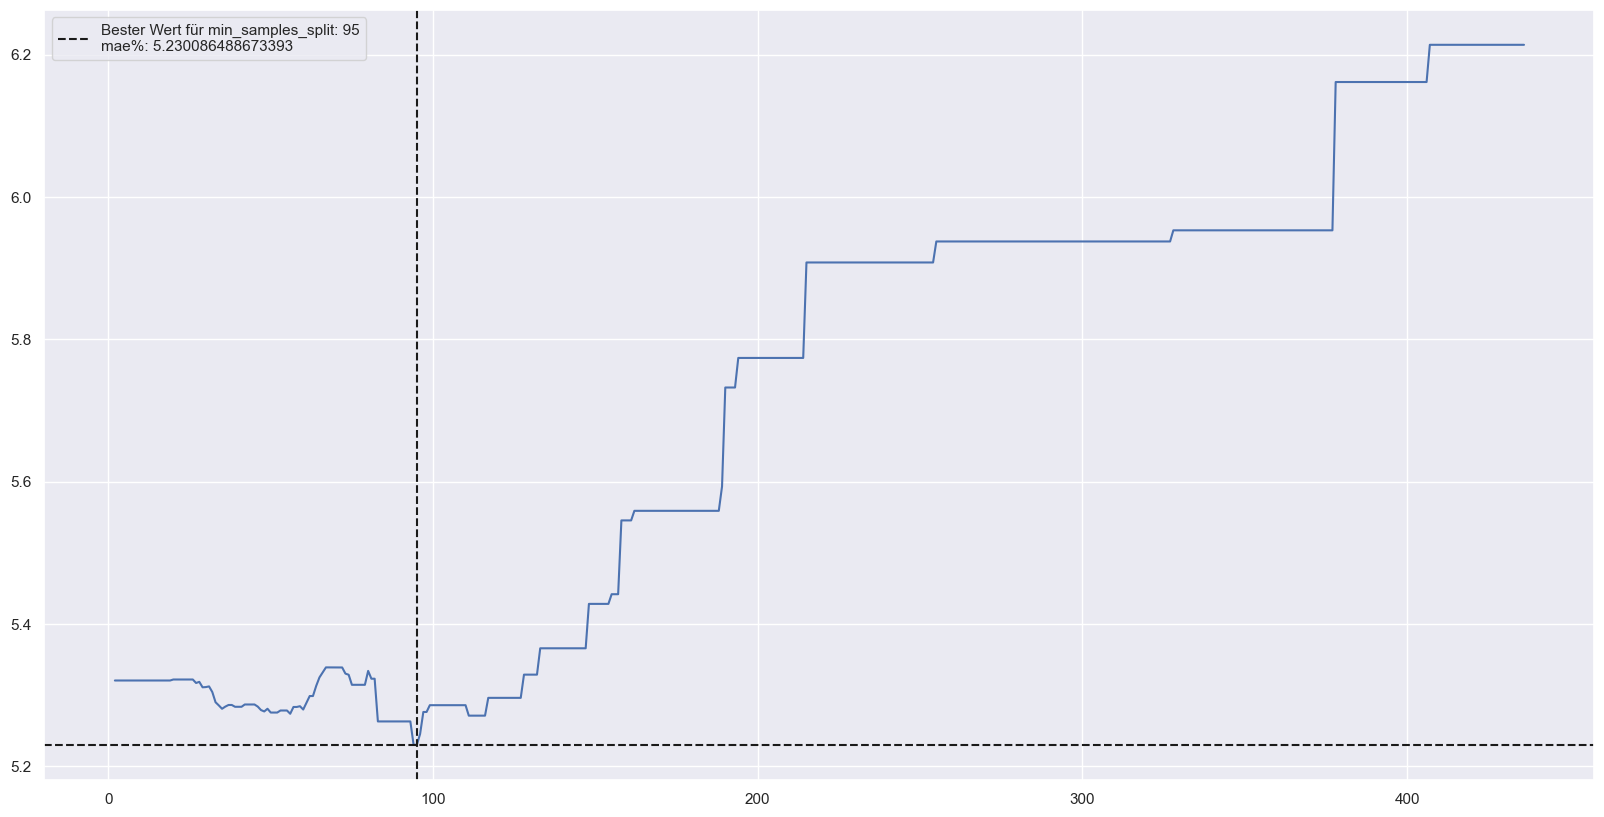

In [16]:
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val) # in die Klammer muss noch etwas rein, was?

## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.
- Was sagen Sie zu dem Ergebnis?
- Wenn Sie mit einem Fehler %mae <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?



Für einen menschlich-lesbaren Baum würde ich entweder die min_samples_leaf erhöhen, die max_depth verringern oder ccp_alpha erhöhen.
Alternativ würde ich einen min_samples_split von 350 wählen.

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Month <= 1.50
|   |   |   |   |--- value: [1515.32]
|   |   |   |--- Month >  1.50
|   |   |   |   |--- value: [1544.10]
|   |   |--- Month >  2.50
|   |   |   |--- value: [1468.15]
|   |--- Month >  3.50
|   |   |--- Month <= 10.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- Month <= 4.50
|   |   |   |   |   |--- value: [1403.74]
|   |   |   |   |--- Month >  4.50
|   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |--- value: [1330.89]
|   |   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |   |--- Month <= 7.50
|   |   |   |   |   |   |   |--- Weekday <= 2.50
|   |   |   |   |   |   |   |   |--- Month <= 6.50
|   |   |   |   |   |   |   |   |   |--- value: [1388.95]
|   |   |   |   |   |   |   |   |--- Month >  6.50
|   |   |   |   |   |   |   |   |   |--- value: [1372.15]
|   |   |   |   |   |   |   |--- Weekday >  2.50
|   |   |   |   |   |   |   |   |--- Month <= 5.5

c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


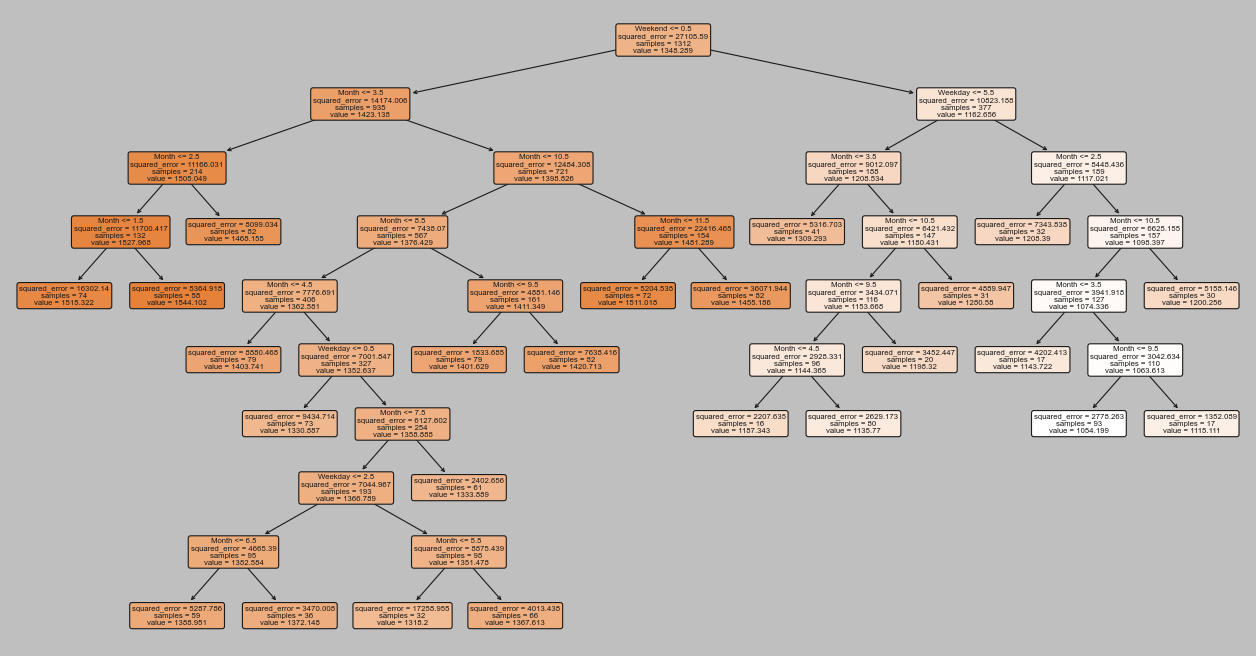

In [22]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)

y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_val, y_val, output=True)


|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- value: [1505.05]
|   |--- Month >  3.50
|   |   |--- Month <= 10.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- Month <= 4.50
|   |   |   |   |   |--- value: [1403.74]
|   |   |   |   |--- Month >  4.50
|   |   |   |   |   |--- value: [1352.64]
|   |   |   |--- Month >  8.50
|   |   |   |   |--- value: [1411.35]
|   |   |--- Month >  10.50
|   |   |   |--- value: [1481.29]
|--- Weekend >  0.50
|   |--- Weekday <= 5.50
|   |   |--- value: [1208.53]
|   |--- Weekday >  5.50
|   |   |--- value: [1117.02]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']
Mittelwert der wahren Label 1343.83
MAE 80.0
MSE 11461.8936
MAE% 5.953152243722058
MAPE% 6.277243798836469
RMSE% 7.966818935823501


c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


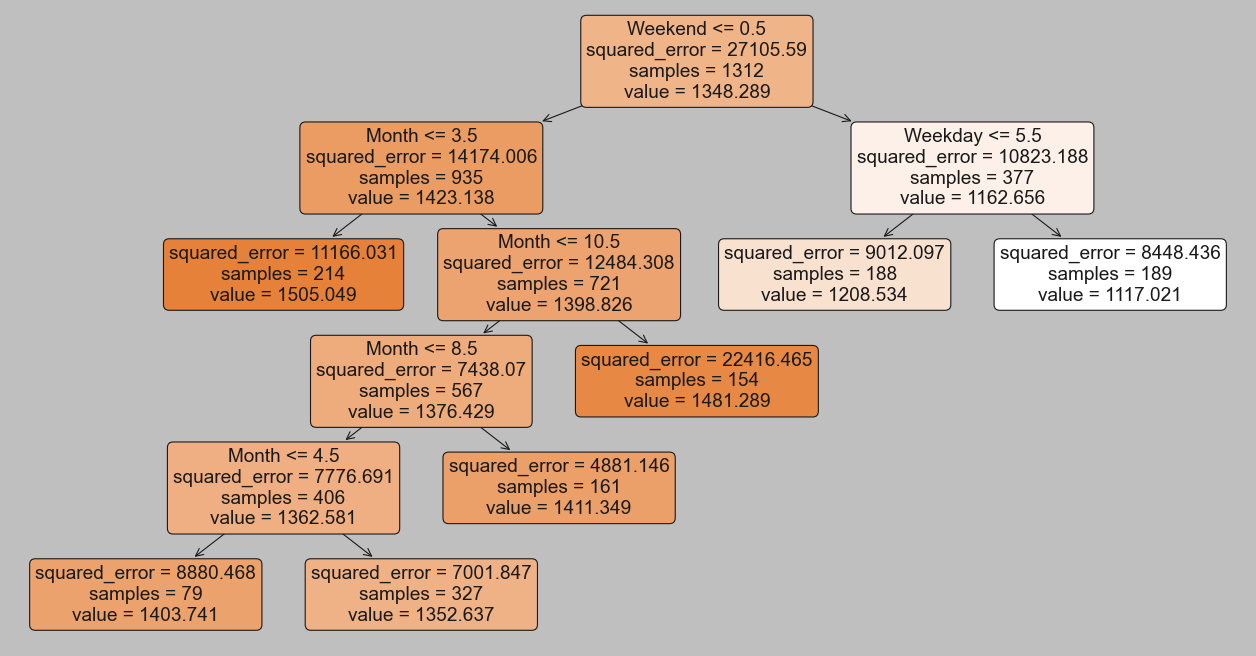

In [20]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar

# Diese Zeile wieder einkommentieren und anpassen
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split=350, output=True) 


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


Antwort:

Ja, der kleinere Baum hat nur eine kleine Abweichung vom großen Baum.

In [23]:
# Performance des großen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

# Performance des kleinen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)


Mittelwert der wahren Label 1348.9
MAE 68.8536
MSE 9253.9611
MAE% 5.104438023453387
MAPE% 5.340868917735648
RMSE% 7.131571670030852

Mittelwert der wahren Label 1348.9
MAE 74.9678
MSE 10490.9815
MAE% 5.557711287654897
MAPE% 5.8362009007068565
RMSE% 7.593281096064191


c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\manue\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
